# Débruitage et compression par transformée en ondelettes rapide
## ELE8812 - Hiver 2018 (Joël Lefebvre)

Pour une version interactive de ce notebook: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/joe-from-mtl/ele8812_Cours_AnalyseMultiresolution/master?filepath=notebooks%2FDemo_Debruitage_Compression.ipynb)

In [1]:
import imageio
import numpy as np
import pywt
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Parameters
plt.style.use('seaborn-poster')
plt.rcParams['axes.linewidth'] = 3

waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
thresholdTypes = ['hard', 'soft']
thresholdValues = widgets.FloatSlider(0.05, min=0.0, max=1.0, step=0.01, description='Threshold Value', continuous_update=False)
displayTypes = ['decomposition', 'details_histogram', 'thresholded_decomposition', 'denoised_image', 'composite']
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3','sym4','sym5','sym6']

## Image a débruiter

In [3]:
imageSelector = widgets.Dropdown(options={'Vase': '../images/Vase.tif', 'Lenna': '../images/Lenna.tif', 
                                          'IRM - Genou': '../images/IRMgenou.tif', 'CT - Thorax': '../images/CTthorax.tif',
                                          'CT - Crane': '../images/CTcrane.tif'},
    value='../images/IRMgenou.tif',
    description='Image:',
)

In [4]:
imageSelector

Dropdown(description='Image:', index=2, options={'Vase': '../images/Vase.tif', 'Lenna': '../images/Lenna.tif', 'IRM - Genou': '../images/IRMgenou.tif', 'CT - Thorax': '../images/CTthorax.tif', 'CT - Crane': '../images/CTcrane.tif'}, value='../images/IRMgenou.tif')

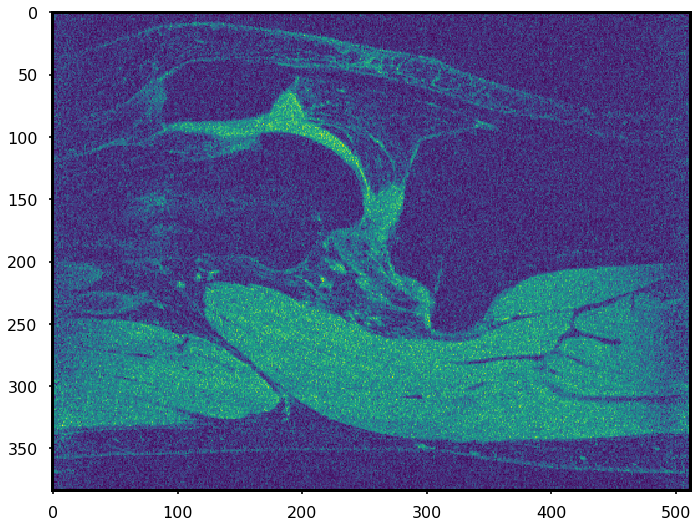

In [5]:
img = imageio.imread(imageSelector.value)
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img); plt.show()

In [6]:
# Décomposition en ondelettes
def wavelet_decomposition_denoising(img, wavelet='haar', nLevels=1, thresholdType='hard', thresholdValue=0.05, displayType='decomposition', displayCompressionRate=False): 
    coeffs = pywt.wavedec2(img, wavelet, level=nLevels)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    arr_p = np.copy(arr)
    arr_p[np.abs(arr) < thresholdValue] = 0.0
    if thresholdType == 'soft':
        arr_p[arr >= thresholdValue] -= thresholdValue
        arr_p[arr <= -thresholdValue] += thresholdValue
    arr_p[coeff_slices[0]] = arr[coeff_slices[0]]
    
    coeffs_p = pywt.array_to_coeffs(arr_p, coeff_slices, output_format='wavedec2')
    img_p = pywt.waverec2(coeffs_p, wavelet)
    
    if displayCompressionRate:
        details_mask = np.ones_like(arr, dtype=bool)
        details_mask[coeff_slices[0]] = False
        compression_rate = np.sum(arr_p[details_mask] == 0) / arr_p.size
        error_rate = np.sqrt(np.sum((img - img_p)**2) / np.sum(img**2))
        print("Compression rate: {:.2f}%".format(compression_rate * 100))
        print("Error (RMS): {:.2f}%".format(error_rate * 100))
    if displayType == 'decomposition':
        plt.imshow(arr); plt.show()
    elif displayType == 'details_histogram':
        details_mask = np.ones_like(arr, dtype=bool)
        details_mask[coeff_slices[0]] = False
        plt.hist(arr[details_mask].ravel(), 64, log=True); plt.show()
    elif displayType == 'thresholded_decomposition':
        plt.imshow(arr_p); plt.show()
    elif displayType == 'denoised_image':
        plt.imshow(img_p); plt.show()
    elif displayType == 'composite':
       
        plt.figure(figsize=(16,5))
        plt.subplot(131); plt.imshow(img); plt.title('Originale')
        plt.subplot(132); plt.imshow(img_p); plt.title(u'Débruitée / Compressée')
        plt.subplot(133); plt.imshow(img - img_p, cmap='RdBu'); plt.title(u'Différence')
        plt.show()

In [7]:
def display_thresholdTypes(thresh = 0.25):
    x = np.linspace(-1,1,512)
    y = x * 1.0
    y_ht = np.copy(y)
    y_ht[np.abs(y)<thresh] = 0.0
    y_st = np.copy(y)
    y_st[np.abs(y)<thresh] = 0.0
    y_st[y<=-thresh] = y_st[y<=-thresh] + thresh
    y_st[y>=thresh] = y_st[y>=thresh] - thresh

    plt.figure(figsize=(15,5))
    plt.subplot(121); plt.plot(x, y_ht)
    plt.grid(True)
    plt.axvline(thresh, color='red', alpha=0.75); plt.axvline(-thresh, color='red', alpha=0.75)
    plt.title('Hard Thresholding (T=0.25)')

    plt.subplot(122); plt.plot(x, y_st)
    plt.grid(True)
    plt.axvline(thresh, color='red', alpha=0.75); plt.axvline(-thresh, color='red', alpha=0.75)
    plt.title('Soft Thresholding (T=0.25)')
    plt.show()

## Theshold types

### Hard threshold
\begin{equation}
I = \left\{ \begin{matrix} I & \text{if }I \geq I_{thresh}\\ 0 & \text{otherwise}\end{matrix} \right.
\end{equation}

### Soft threshold
\begin{equation}
I = \left\{ \begin{matrix} I - I_{thresh} & \text{if }I \geq I_{thresh}\\ I + I_{thresh} & \text{if } I \leq -I_{thresh} \\ 0 & \text{otherwise}\end{matrix} \right.
\end{equation}

## Threshold Types Demo

In [8]:
interactive(display_thresholdTypes, thresh=(0,1,0.05))

interactive(children=(FloatSlider(value=0.25, description='thresh', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

## Denoising & Compression Demo

In [9]:
interactive(wavelet_decomposition_denoising, img = fixed(img), wavelet=waveletList, nLevels=(1,6), 
            thresholdType=thresholdTypes, thresholdValue=thresholdValues, displayType=displayTypes)

interactive(children=(Dropdown(description='wavelet', options=('haar', 'db2', 'db3', 'db4', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6'), value='haar'), IntSlider(value=1, description='nLevels', max=6, min=1), Dropdown(description='thresholdType', options=('hard', 'soft'), value='hard'), FloatSlider(value=0.05, continuous_update=False, description='Threshold Value', max=1.0, step=0.01), Dropdown(description='displayType', options=('decomposition', 'details_histogram', 'thresholded_decomposition', 'denoised_image', 'composite'), value='decomposition'), Checkbox(value=False, description='displayCompressionRate'), Output()), _dom_classes=('widget-interact',))